<a href="https://colab.research.google.com/github/SEOYUNJE/Lung-Image-Analysis/blob/main/Chest_X_Ray_%7C_Lung_Diseases%5BEffNet%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/seanbearden/tf-efficientnet-noisy-student-weights')
od.download('https://www.kaggle.com/datasets/seoyunje/cxr-unet')
od.download('https://www.kaggle.com/datasets/seoyunje/rapid-cxr-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seanbearden/tf-efficientnet-noisy-student-weights


100%|██████████| 637M/637M [00:38<00:00, 17.4MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/cxr-unet


100%|██████████| 151M/151M [00:10<00:00, 14.8MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/rapid-cxr-dataset


100%|██████████| 1.67G/1.67G [01:38<00:00, 18.2MB/s]


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 512X512
    
- `Label Unique`: Label Unique>=2 & No Finding 삭제
    
- `Cropped Segment Lung`: 적용(No Finding, Edema)
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (4,4)

- `Label Smoothing`: 0.2
    
- `Loss`: CategorialCrossEntropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip(p=0.5)
    
- `Strong Augment`: X
  
- `BackBone Model`: TF ResNet18
    
- `Freezing Layer`: 10% Layers
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [2]:
import gc
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
from tqdm import tqdm

## tensorflow version
import tensorflow as tf
from tensorflow.keras import *

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

import tensorflow.keras.backend as K, gc


import warnings
import albumentations as albu
warnings.filterwarnings('ignore')

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_MODELS_FROM = None
LOAD_SEGMENTATION_FROM = '/content/cxr-unet/'

tensorflow version:  2.17.0
Using 1 GPUs


In [3]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [5]:
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else:
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [6]:
df = pd.read_csv('/content/rapid-cxr-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', '*','*','*', '*'))}

df['path'] = df['Image Index'].map(tmp)

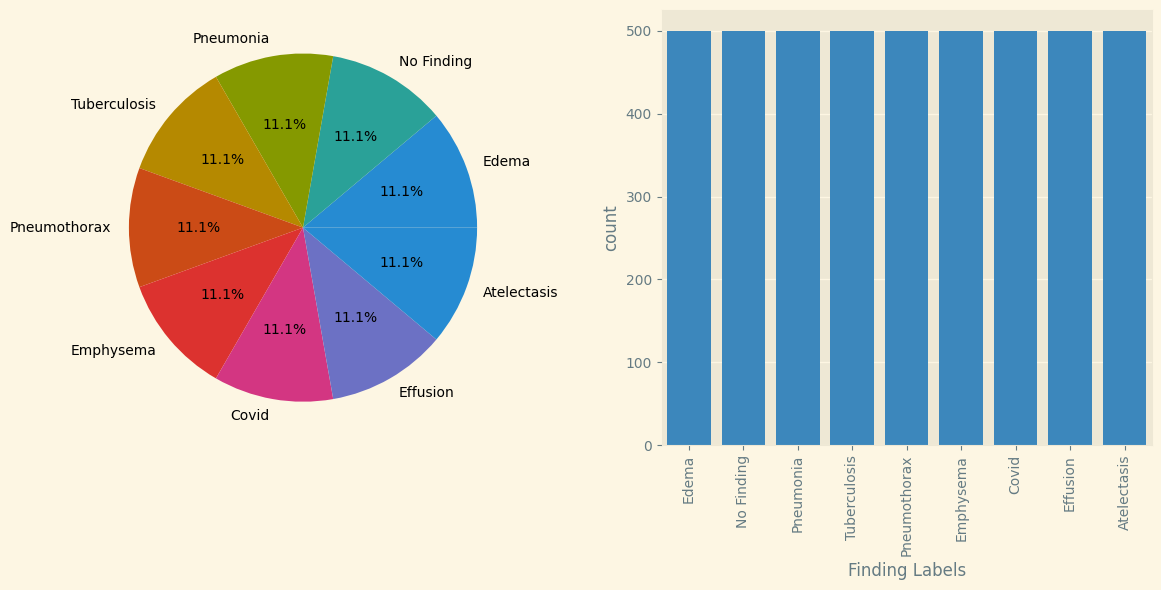

In [7]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**PA vs AP**

<Figure size 1200x600 with 0 Axes>

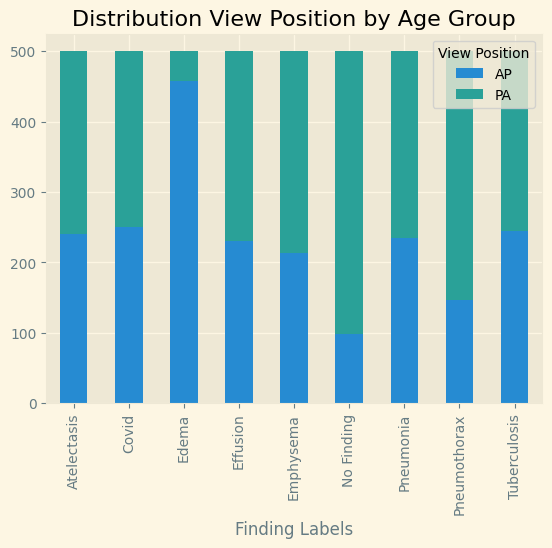

In [8]:
tmp = df.groupby(['Finding Labels','View Position']).size().unstack()
plt.figure(figsize=(12,6))
tmp.plot(kind='bar', stacked=True)
plt.title('Distribution View Position by Age Group')
plt.show()

**Train & Test Split**

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [10]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
TARGET = df_train.columns[-9:].tolist()

In [11]:
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Pneumothorax',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Segmented Lung from Unet Model</b></div>

**Install TF Segmentation**

In [12]:
!pip install -q -U segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00


In [13]:
os.environ["SM_FRAMEWORK"] = 'tf.keras'
import segmentation_models

Segmentation Models: using `tf.keras` framework.


In [14]:
from segmentation_models import Unet
preprocess = segmentation_models.get_preprocessing('resnet18')

def build_unet():

    unet_model = Unet('resnet18', input_shape=(512,512,3), classes=1, activation='sigmoid')

    ## Freezing Layers(10%)
    for layer in unet_model.layers[:len(unet_model.layers)//10]:
        layer.trainable=False

    dice_loss = segmentation_models.losses.DiceLoss()
    dice_metric = segmentation_models.metrics.FScore(threshold=0.5)

    opt = optimizers.Adam(learning_rate=1e-4)

    unet_model.compile(optimizer=opt, loss=dice_loss, metrics=[dice_metric])

    return unet_model

In [15]:
import albumentations as albu

class MaskGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, preprocess=None):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocess = preprocess
        self.on_epoch_end()
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))

    def __len__(self):
        # Drop_Last = False
        return int(np.ceil(len(self.data) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X

    def __data_generation(self, indexes):
        X = np.zeros((len(indexes),512,512,3), dtype='float32')

        for j,i in enumerate(indexes):
            ## Image
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((512,512), Image.Resampling.LANCZOS) # DownSampling
            img = np.array(img) # PIL Object -> np.array(uint8)
            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            X[j,] = img
            if self.preprocess != None: X = self.preprocess(X)


        return X

In [16]:
gen = MaskGenerator(df_train, batch_size=32, shuffle=False, preprocess=preprocess)

K.clear_session()
with strategy.scope(): unet = build_unet()

unet.load_weights(f'{LOAD_SEGMENTATION_FROM}UNet_f0.weights.h5')

all_mask = unet.predict(gen, verbose=1)

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 96s 811ms/step


In [17]:
all_mask = np.where(all_mask >= 0.5, 1, 0)
all_mask = (all_mask * 255).astype('uint8').squeeze()

all_mask = cv2.dilate(all_mask, None, iterations=2)
all_mask = cv2.erode(all_mask, None, iterations=1)

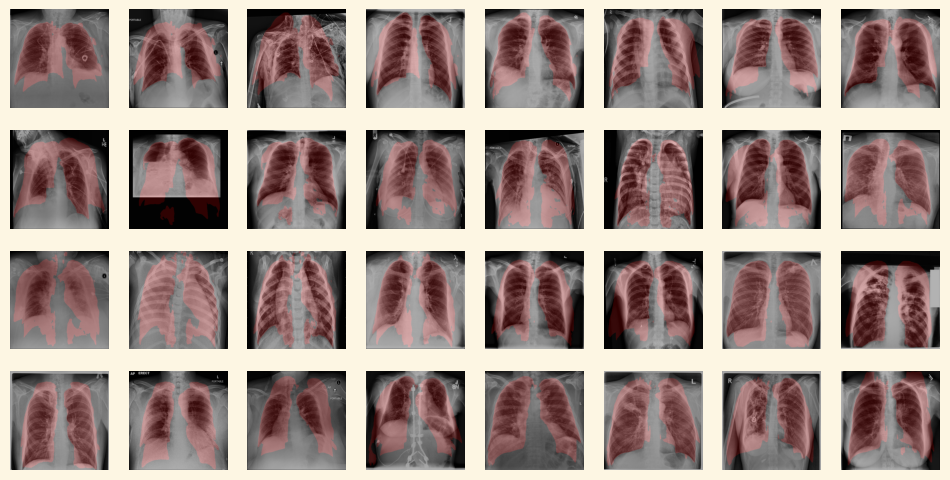

In [18]:
BATCH_IDX = 0

gen = MaskGenerator(df_train, batch_size=32, shuffle=False)


for batch_idx, X in enumerate(gen):
    plt.figure(figsize=(12,6))
    for i in range(32):
        plt.subplot(4,8, i+1)
        img = X[i,]
        img = img.astype('uint8')
        tmp = all_mask[i,]
        mask = cv2.cvtColor(all_mask[i,], cv2.COLOR_GRAY2RGB)
        mask[tmp>0,0] = 150
        mask[tmp>0,1] = 0
        mask[tmp>0,2] = 0

        img = cv2.addWeighted(img, 0.7, mask, 0.3, 0)

        plt.imshow(img)
        plt.axis('off')

    if BATCH_IDX == batch_idx: break
    plt.tight_layout()
    plt.show()


In [19]:
def crop_imgs(path, mask):

    ### First Step: Get the original Image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))

    img = Image.open(path).convert('L')
    img = img.resize((512,512), Image.Resampling.LANCZOS) # DownSampling
    img = np.array(img) # PIL Object -> np.array(uint8)
    img = clahe.apply(img)
    img = np.expand_dims(img, axis=-1)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    ### Second Step: Find First, Second Biggest Contours
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    ### Thrid Step: Find the Extreme Points
    if len(cnts) == 1:
        c0 = cnts[0]
        combined_contour = c0
        img_cnt = cv2.drawContours(img.copy(), [c0], -1, (0,255,255), 5)
    else:
        c0 = cnts[0]
        c1 = cnts[1]
        combined_contour = np.vstack((c0, c1))
        img_cnt = cv2.drawContours(img.copy(), [c0], -1, (0,255,255), 5)
        img_cnt = cv2.drawContours(img_cnt, [c1], -1, (0,255,255), 5)


    extLeft = tuple(combined_contour[combined_contour[:,:,0].argmin()][0])  # x좌표 최소
    extRight = tuple(combined_contour[combined_contour[:,:,0].argmax()][0])  # x좌표 최대
    extTop = tuple(combined_contour[combined_contour[:,:,1].argmin()][0])  # y좌표 최소
    extBot = tuple(combined_contour[combined_contour[:,:,1].argmax()][0])  # y좌표 최대

    new_img = img[extTop[1]:extBot[1],
                 extLeft[0]:extRight[0]].copy()

    # add extreme points
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 10, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 10, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 10, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 10, (255, 255, 0), -1)

    return new_img, img_pnt

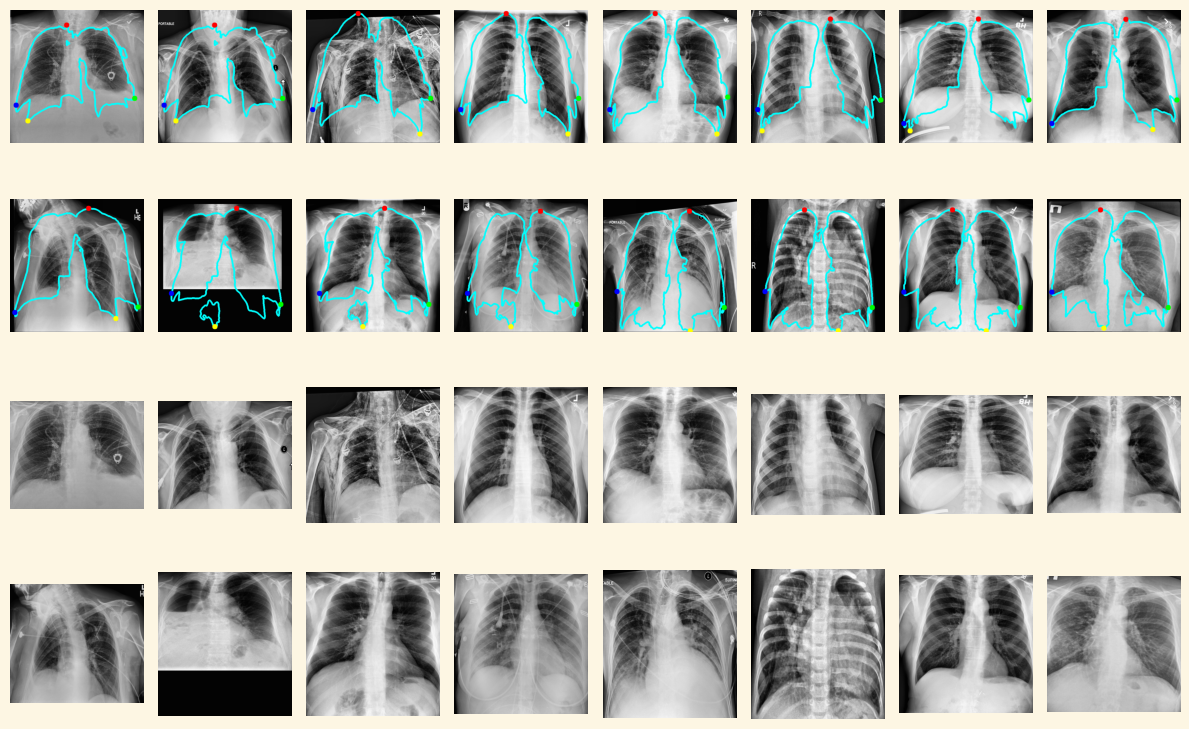

In [20]:
plt.figure(figsize=(12,8))

for i in range(16):
    path = df_train.iloc[i]['path']
    cropped_img, point_img = crop_imgs(path, all_mask[i])

    plt.subplot(4,8,i+1)
    plt.imshow(point_img)
    plt.axis('off')
    plt.subplot(4,8,i+17)
    plt.imshow(cropped_img)
    plt.axis('off')

plt.tight_layout()
plt.show()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build DataGenerator</b></div>

In [21]:
import albumentations as albu
print(albu.__version__)

1.4.13


In [78]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, mask, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.mask = mask
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    def __len__(self):

        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y

    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):

        X = np.zeros((len(indexes),512,512,3), dtype='float32')
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']

            if row['Finding Labels'] in ['No Finding','Edema']:
                cropped_img, _ = crop_imgs(path, self.mask[i])  # cropped_imgs have different img sizes
                cropped_img = cv2.resize(cropped_img, (512, 512), interpolation=cv2.INTER_LANCZOS4)

                # FillNaN
                m = np.nanmean(cropped_img)
                cropped_img = np.nan_to_num(cropped_img, nan=m)
                X[j,] = cropped_img
            else:
                img = Image.open(path).convert('L')
                img = img.resize((512, 512), Image.Resampling.LANCZOS)  # DownSampling
                img = np.array(img)  # PIL Object -> np.array(uint8)
                img = self.clahe.apply(img)
                img = np.expand_dims(img, axis=-1)
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                # FillNaN
                m = np.nanmean(img)
                img = np.nan_to_num(img, nan=m)
                X[j,] = img


            y[j,] = row[TARGET]

        return X,y

    def __augment1(self, img_batch):

        composition = albu.Compose([
            albu.OneOf([
        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=2.5, p=0.5),
        ], p=1.0)
        ])

        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img

        return img_batch


    def __augment2(self, img_batch, mixup_prob=0.1):
        batch_size, height, width, channels = img_batch.shape

        idx = np.random.permutation(batch_size)
        lam = np.random.beta(2.0, 2.0)

        for i in range(batch_size):
            if np.random.rand() <= mixup_prob:
                j = idx[i]

                img_batch[i] = img_batch[i] * lam + img_batch[j] * (1-lam)

        return img_batch


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Build EfficientNet Model</b></div>

In [59]:
!pip install -q -U git+https://github.com/qubvel/efficientnet

import efficientnet.tfkeras as efn

  Preparing metadata (setup.py) ... done


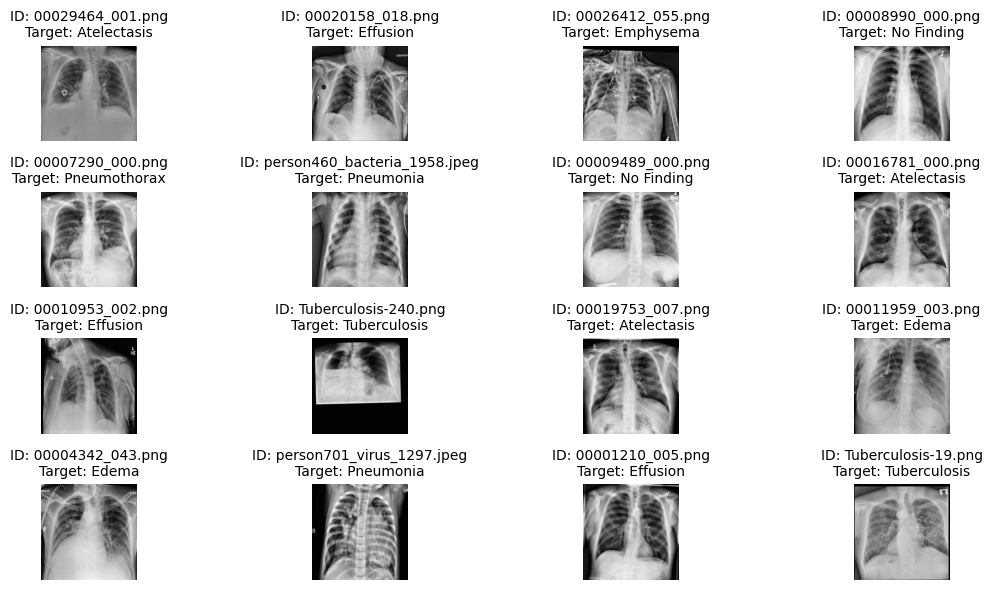

In [79]:
ROWS = 4; COLS = 4; BATCHES = 1

gen = DataGenerator(df_train, all_mask, batch_size=16, shuffle=False, augment1=True, augment2=False, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

**Macro F1 Score**

In [80]:
def f1(y_true, y_pred):
    # Calculate the F1 score for each class
    f1_scores = []
    num_classes = K.int_shape(y_pred)[-1]  # (batch_size, output_dims = num_classes)

    # Get the true and predicted class indices
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1) # For Label Smoothing(in CCE)

    for i in range(num_classes):

        true_positives = K.sum(K.cast(tf.logical_and(K.equal(y_true, i), K.equal(y_pred, i)), dtype=tf.float32))
        possible_positives = K.sum(K.cast(K.equal(y_true, i), dtype=tf.float32))
        predicted_positives = K.sum(K.cast(K.equal(y_pred, i), dtype=tf.float32))

        recall = true_positives / (possible_positives + K.epsilon())
        precision = true_positives / (predicted_positives + K.epsilon())

        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        f1_scores.append(f1_score)

    # Calculate the macro-average F1 score
    macro_f1_score = K.mean(tf.stack(f1_scores))
    return macro_f1_score

In [81]:
def build_model():
    inp = layers.Input(shape=(512,512,3))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(512,512,3))
    base_model.load_weights('/content/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')

    # Freezing Layers
    for layer in base_model.layers[:len(base_model.layers)//10]:
        layer.trainable = False

    # Output
    x = base_model(inp)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(len(TARGET), activation='softmax', dtype='float32')(x)

    # Compile
    model = Model(inputs=inp, outputs=x, name='efficientnet')
    loss = losses.CategoricalCrossentropy(label_smoothing=0.2)
    opt = optimizers.Adam(learning_rate=1e-3)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy',f1])

    return model

In [82]:
from tensorflow.keras.utils import plot_model
model = build_model()
model.summary()

#plot_model(model, show_shapes=True, show_layer_names=True)

Model: "efficientnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnet-b0 (Functional)         │ (None, 16, 16, 1280)        │       4,049,564 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │          11,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,061,093 (15.49 MB)

 Trainable params: 4,013,529 (15.31 MB)

 Non-trainable params: 47,564 (185.80 KB)

In [83]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

EPOCHS = 10

es = EarlyStopping(monitor='val_f1', mode='max', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_f1', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>6. Train CNN Model</b></div>

In [84]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 161s 685ms/step - accuracy: 0.5510 - f1: 0.4353 - loss: 1.6044 - val_accuracy: 0.5486 - val_f1: 0.4459 - val_loss: 1.7162 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 125s 671ms/step - accuracy: 0.7253 - f1: 0.5932 - loss: 1.3340 - val_accuracy: 0.5417 - val_f1: 0.4664 - val_loss: 1.6585 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 125s 671ms/step - accuracy: 0.7834 - f1: 0.6484 - loss: 1.2435 - val_accuracy: 0.7486 - val_f1: 0.7120 - val_loss: 1.3470 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8144 - f1: 0.6933 - loss: 1.1959
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
180/180 ━━━━━━━━━━━━━━━━━━━━ 123s 659ms/step - accuracy: 0.8144 - f1: 0.6933 - loss: 1.1959 - val_accuracy: 0.7556 - val_f1: 0.7114 - val_loss: 1.2666 - learning_rat

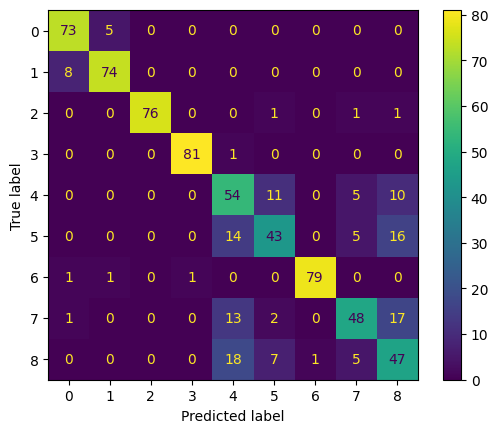

In [85]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):

    print('#'*25)
    print(f'### Fold {i+1}')

    train_gen = DataGenerator(df_train[df_train['Fold'] != i], all_mask[df_train['Fold'].values != i],shuffle=True, augment1=True, augment2=False, batch_size=16, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], all_mask[df_train['Fold'].values == i],shuffle=False, batch_size=32, preprocess=efn.preprocess_input)

    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)

    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'EffNet_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid F1'].append(history.history['val_f1'])
        all_history['Train F1'].append(history.history['f1'])
        all_history['Valid Accuracy'].append(history.history['val_accuracy'])
        all_history['Train Accuracy'].append(history.history['accuracy'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_f{i}.weights.h5')

    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['Image Index'].values)

    plt.style.use('default')
    cm = confusion_matrix(np.argmax(df_train[df_train['Fold'] == i][TARGET].values, axis=1), np.argmax(oof, axis=1), labels=[x for x in range(len(TARGET))])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(len(TARGET))])
    disp.plot()
    plt.show()

    del model, oof, train_gen, valid_gen
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

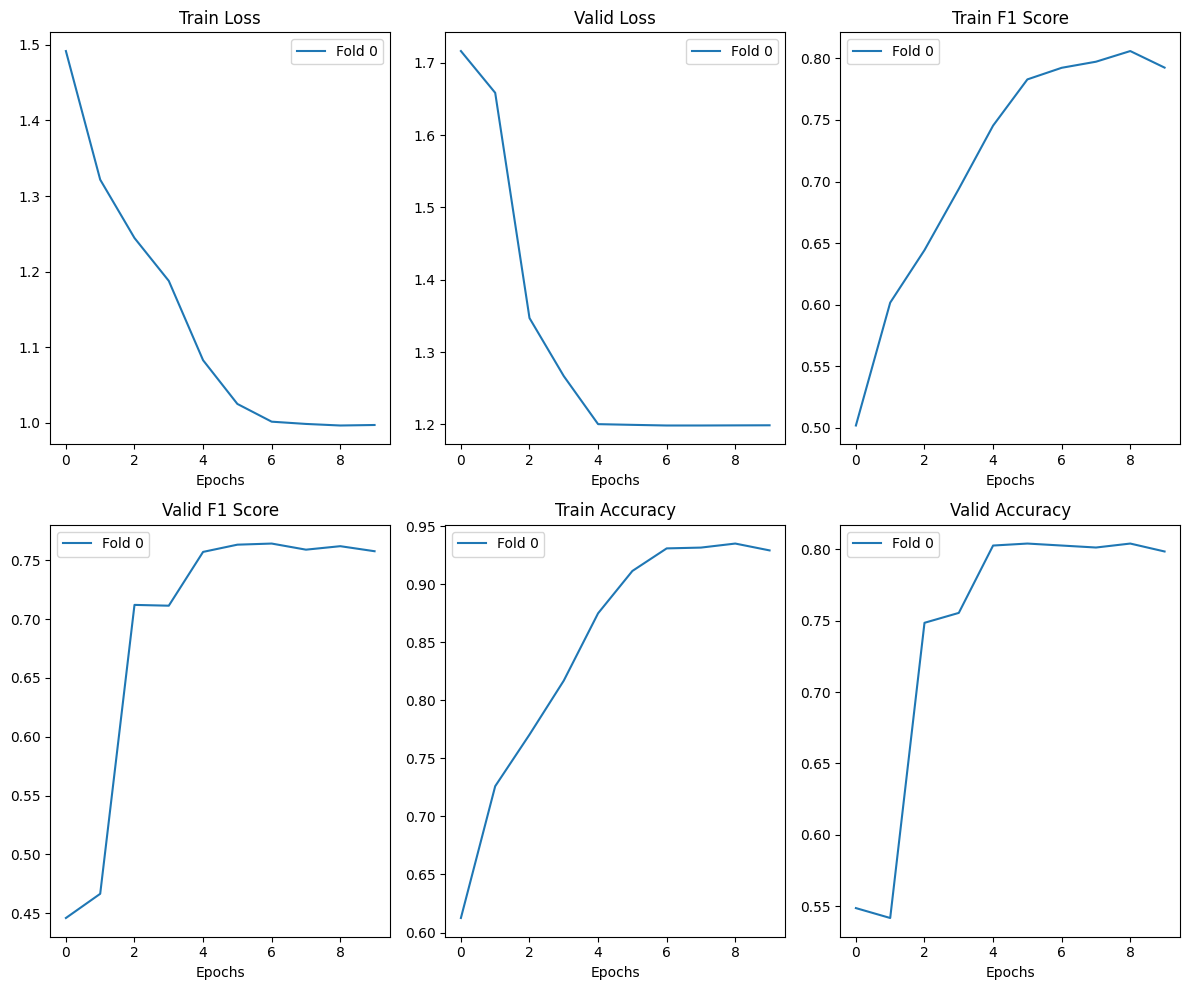

In [86]:
if LOAD_MODELS_FROM is None:
    plt.figure(figsize=(12,10))
    plt.subplot(2,3,1)
    plt.title('Train Loss')
    for fold, i in enumerate(all_history['Train Loss']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,2)
    plt.title('Valid Loss')
    for fold, i in enumerate(all_history['Valid Loss']):
        plt.plot(i,label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,3)
    plt.title('Train F1 Score')
    for fold, i in enumerate(all_history['Train F1']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,4)
    plt.title('Valid F1 Score')
    for fold, i in enumerate(all_history['Valid F1']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,5)
    plt.title('Train Accuracy')
    for fold, i in enumerate(all_history['Train Accuracy']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,6)
    plt.title('Valid Accuracy')
    for fold, i in enumerate(all_history['Valid Accuracy']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()



    plt.tight_layout()
    plt.show()

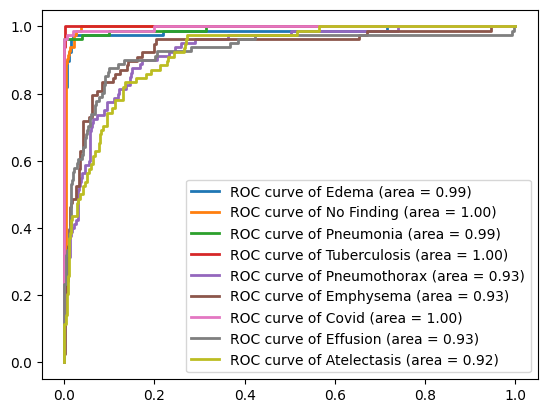

In [87]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()


In [88]:
# Accuracy
accuracy = accuracy_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1))
print('Accuracy for Train Set =', accuracy)

# F1 Score
macro_f1 = f1_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1) , average='macro')
print('F1 Score for Train Set =', macro_f1)

Accuracy for Train Set = 0.7986111111111112
F1 Score for Train Set = 0.7986763347166955


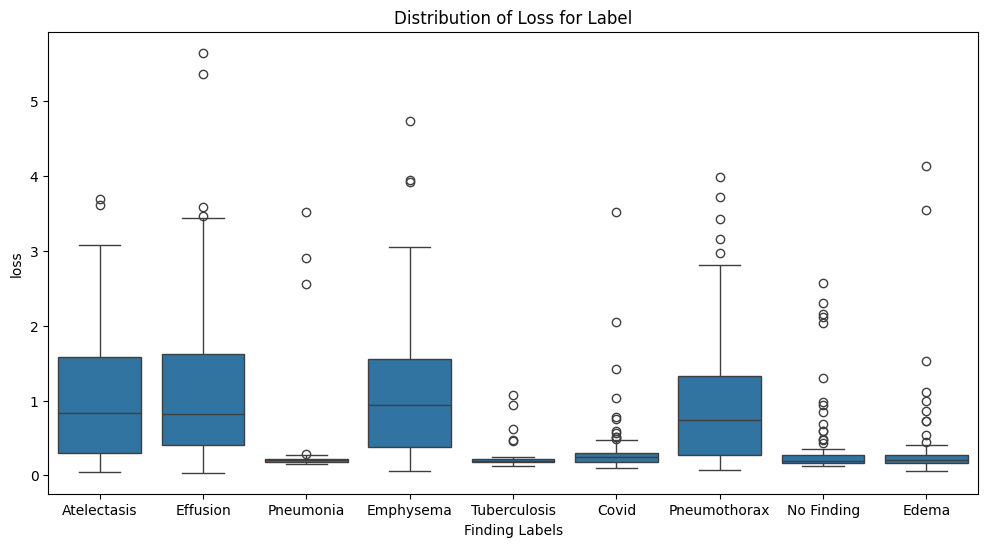

In [89]:
cce = tf.keras.losses.categorical_crossentropy(all_true, all_oof)

all_index = pd.DataFrame(all_index, columns=['Image Index'])
df_loss = pd.DataFrame(cce.numpy(), columns=['loss'])
df_loss = pd.concat([df_loss,all_index], axis=1)
df_loss = df_loss.merge(df_train, how='left', on='Image Index')

plt.figure(figsize=(12,6))

plt.title('Distribution of Loss for Label')
sns.boxplot(x='Finding Labels', y='loss', data=df_loss)
plt.show()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>7. Inference</b></div>

In [90]:
gen = MaskGenerator(df_test, batch_size=32, shuffle=False, preprocess=preprocess)

K.clear_session()
with strategy.scope(): unet = build_unet()

unet.load_weights(f'{LOAD_SEGMENTATION_FROM}UNet_f0.weights.h5')

test_mask = unet.predict(gen, verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 782ms/step


In [91]:
test_mask = np.where(test_mask >= 0.5, 1, 0)
test_mask = (test_mask * 255).astype('uint8').squeeze()

test_mask = cv2.dilate(test_mask, None, iterations=2)
test_mask = cv2.erode(test_mask, None, iterations=1)

Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
Accuracy for Test Set = 0.8066666666666666
F1 Score for Test Set = 0.8129877566765893


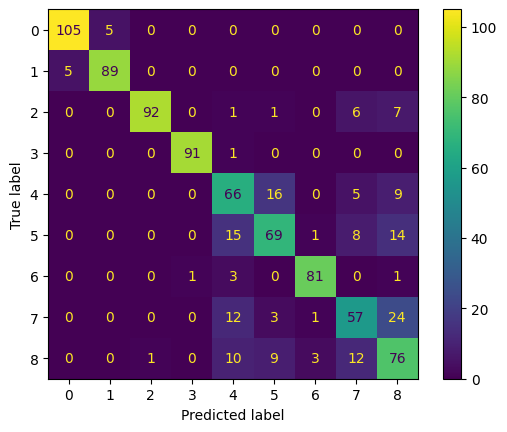

In [92]:
preds = []
model = build_model()

## No TTA
test_gen = DataGenerator(df_test, test_mask, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_f{i}.weights.h5')
    else:
        model.load_weights(f'EffNet_f{i}.weights.h5')

    pred = model.predict(test_gen, verbose=1)

preds.append(pred)
pred_res = np.mean(preds,axis=0)

# Accuracy
accuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))
print('Accuracy for Test Set =', accuracy)

# F1 Score
f1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro')
print('F1 Score for Test Set =', f1)

cm = confusion_matrix(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), labels=[x for x in range(len(TARGET))])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(len(TARGET))])
display.plot()
plt.show()

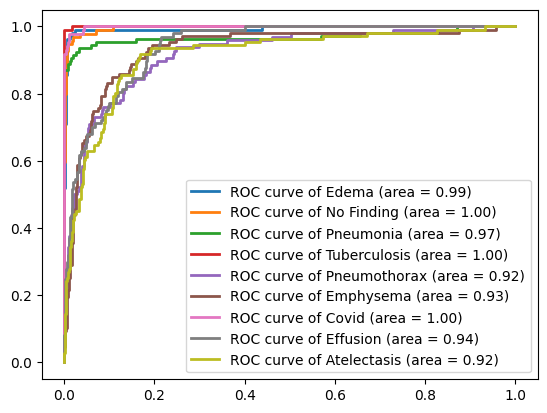

In [93]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], pred_res[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()

#### TTA
___

In [57]:
## TTA
test_gen = DataGenerator(df_test, test_mask, shuffle=False, augment1=True, batch_size=64, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_f{i}.weights.h5')
    else:
        model.load_weights(f'EffNet_f{i}.weights.h5')

    pred = model.predict(test_gen, verbose=1)

preds.append(pred)
pred_res = np.mean(preds,axis=0)

# Accuracy
accuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))
print('Accuracy for Test Set =', accuracy)

# F1 Score
f1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro')
print('F1 Score for Test Set =', f1)

Fold 1
 9/15 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

KeyboardInterrupt: 